# Data Loading

In [ ]:
# Import CIFAR10 dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
# Create an unlabeled dataset of the training set randomly
import numpy as np
unlabel_ratio = 0.8
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_unlab = x_train[indices[0:int(unlabel_ratio*x_train.shape[0])]] / 255
x_train = x_train[indices[int(unlabel_ratio*x_train.shape[0]):x_train.shape[0]]] / 255
y_unlab = y_train[indices[0:int(unlabel_ratio*y_train.shape[0])]]
y_train = y_train[indices[int(unlabel_ratio*y_train.shape[0]):y_train.shape[0]]]

In [ ]:
IMAGE_SIZE = 32
NUM_CLASSES = 10

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_unlab shape:', x_unlab.shape)
print('y_unlab shape:', y_unlab.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 1)
x_unlab shape: (40000, 32, 32, 3)
y_unlab shape: (40000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# Supervised learning (baseline)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import activations

def create_model(image_size=IMAGE_SIZE):
  model = Sequential()
  # Add the layers
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [ ]:
create_model().summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_10 (Flatten)        (None, 2048)            

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math

BATCH_SIZE = 64
EPOCHS = 50

# Create the model
model = create_model()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle=True)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
157/157 [==============================] - 2s 10ms/step - loss: 1.9193 - accuracy: 0.2898 - val_loss: 197.3306 - val_accuracy: 0.3345
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 1.5498 - accuracy: 0.4336 - val_loss: 260.4752 - val_accuracy: 0.3323
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 1.3878 - accuracy: 0.4978 - val_loss: 249.9387 - val_accuracy: 0.3779
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 1.2928 - accuracy: 0.5300 - val_loss: 298.4782 - val_accuracy: 0.3636
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 1.2070 - accuracy: 0.5691 - val_loss: 243.4183 - val_accuracy: 0.4261
Epoch 6/50
157/157 [==============================] - 1s 8ms/step - loss: 1.0927 - accuracy: 0.6119 - val_loss: 267.5249 - val_accuracy: 0.4051
Epoch 7/50
157/157 [==============================] - 1s 8ms/step - loss: 1.0082 - accuracy: 0.6409 - val_loss: 268.8097 - val_accuracy

# FixMatch

In [ ]:
# Import
import tensorflow as tf
from tensorflow import keras
import math
import sys

In [ ]:
import random

# Define a function that weakly augments the images
def weak_augment(images):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_brightness(images, max_delta=0.2)
  images = tf.image.random_contrast(images, lower=0.2, upper=1.8)
  return images

# Define a function that very strongly augments the images
def strong_augment(images):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_brightness(images, max_delta=0.8)
  images = tf.image.random_contrast(images, lower=0.2, upper=1.8)
  images = tf.image.random_saturation(images, lower=0.2, upper=1.8)
  images = tf.image.random_hue(images, max_delta=0.2)
  return images

# Define a function that creates pseudo labels above a threshold of confidence and assign -1 to the others
def create_pseudo_labels(model, images, threshold):
  predictions = model(images, training=False)
  max_indexes = tf.math.argmax(predictions, axis=1)
  confidence = tf.reduce_max(predictions, axis=1)
  pseudo_labels = tf.where(confidence > threshold, max_indexes, -1)
  return pseudo_labels

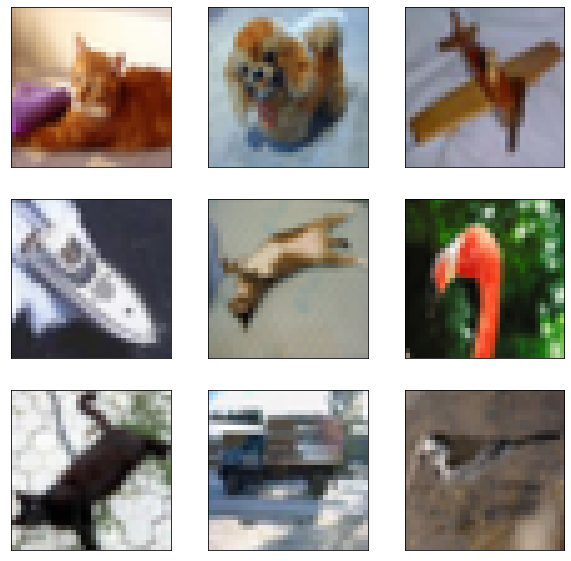

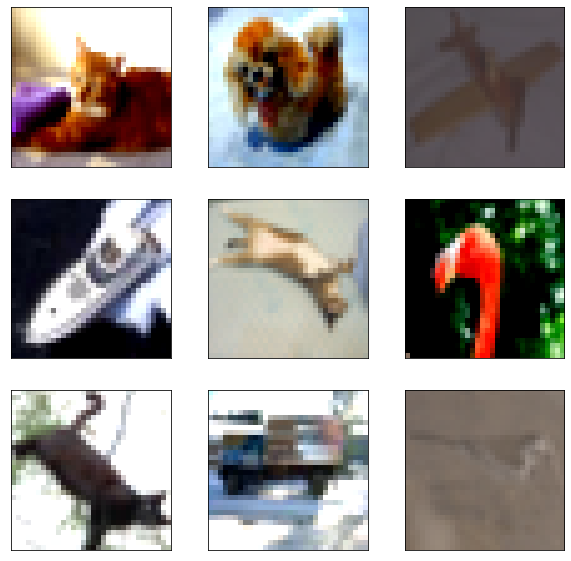

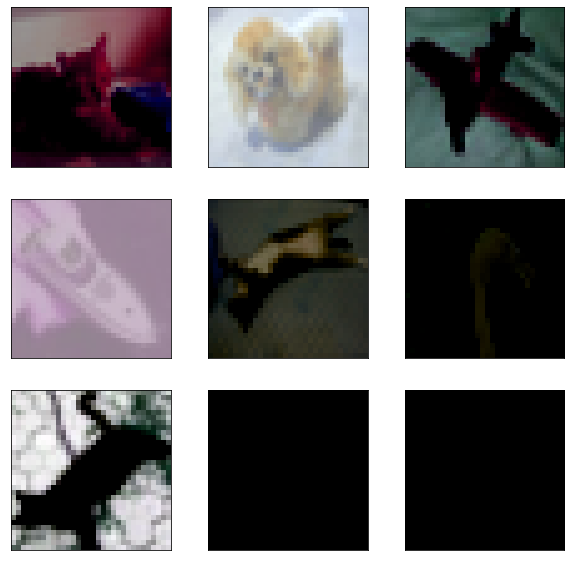

In [ ]:
# Test the augmentation
import matplotlib.pyplot as plt
import numpy as np

# Plot the images
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
plt.show()

# Plot the weakly augmented images
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(weak_augment(x_train[i]))
plt.show()

# Plot the strongly augmented images
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(strong_augment(x_train[i]))
plt.show()

In [ ]:
# Data
x_train_lab = x_train 
y_train_lab = y_train
x_train_unlab = x_unlab

# FixMatch Hyperparameters
mu = 7# size of unlab batch
lambda_u = 1 # loss weight
tau = 0.95 # weakly augmented threshold

# Training parameters
epochs = 500
lr = 1e-4
bs_lab = 32 # lab batch size
bs_unlab = mu * bs_lab # unlab batch size
bs_total = bs_lab + bs_unlab # total batch size
steps_per_epoch = math.floor(x_train_lab.shape[0]/bs_lab)
prev_acc = 0

# Logs
train_acc = []
test_acc = []
losses = []
losses_lab = []
losses_unlab = []
pseudo_lab = []

# Create model
model = create_model(image_size=IMAGE_SIZE) # Note : Better with a pre-trained model

# Training settings
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# metrics
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# indexes
indices_lab = np.arange(x_train_lab.shape[0]) # lab data
indices_unlab = np.arange(x_train_unlab.shape[0]) # unlab data

# Training loop
for epoch in range(epochs):

  # Shuffle the lab data
  np.random.shuffle(indices_lab)
  # Shuffle the unlab data
  np.random.shuffle(indices_unlab)

  # Initialize cumulative losses
  cumul_loss_value = 0
  cumul_loss_value_lab = 0
  cumul_loss_value_unlab = 0

  # Intialize the number of pseudo labels
  num_pseudo_labels = 0

  # Training loop
  for step in range(steps_per_epoch):

    # Get the lab batch
    batch_indices_lab = indices_lab[step*bs_lab:(step+1)*bs_lab]
    x_batch_lab = x_train_lab[batch_indices_lab]
    y_batch_lab = y_train_lab[batch_indices_lab]

    # Get the unlab batch
    batch_indices_unlab = indices_unlab[step*bs_unlab:(step+1)*bs_unlab]
    x_batch_unlab = x_train_unlab[batch_indices_unlab]

    with tf.GradientTape() as tape:
      
      # Get predictions for the lab batch
      y_pred_lab = model(x_batch_lab, training=True)

      # Compute the lab loss
      loss_value_lab = loss_fn(y_batch_lab, y_pred_lab)

      # Get predictions for the unlab batch (weakly augmented)
      x_batch_unlab_wa = weak_augment(x_batch_unlab)

      # Get predictions for the unlab batch (strongly augmented)
      x_batch_unlab_sa = strong_augment(x_batch_unlab)
      y_pred_sa = model(x_batch_unlab_sa, training=True)

      # Compute the loss for valid pseudo labels
      pseudo_labels = create_pseudo_labels(model, x_batch_unlab_wa, tau)
      filtered_pseudo_labels = tf.boolean_mask(pseudo_labels, pseudo_labels != -1)
      filtered_y_pred_sa = tf.boolean_mask(y_pred_sa, pseudo_labels != -1)
      filtered_x_unlab = tf.boolean_mask(x_batch_unlab, pseudo_labels != -1)

      # Compute the loss for the unlab batch if there are valid pseudo labels
      if filtered_pseudo_labels.shape[0] > 0:
        loss_value_unlab = loss_fn(filtered_pseudo_labels, filtered_y_pred_sa)
        num_pseudo_labels += filtered_pseudo_labels.shape[0]
      else:
        loss_value_unlab = 0

      # Compute the total loss
      loss_value = loss_value_lab + lambda_u * loss_value_unlab

    # Compute the gradients
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Update the weights
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Update the cumulative loss
    cumul_loss_value += loss_value 
    cumul_loss_value_lab += loss_value_lab
    cumul_loss_value_unlab += loss_value_unlab

    # Update the training accuracy
    train_acc_metric.update_state(np.expand_dims(y_batch_lab,1), y_pred_lab)

  cumul_loss_value = cumul_loss_value / steps_per_epoch
  cumul_loss_value_lab = cumul_loss_value_lab / steps_per_epoch
  cumul_loss_value_unlab = cumul_loss_value_unlab / steps_per_epoch
  
  # Calculate the average pseudo labels
  num_pseudo_labels = int(num_pseudo_labels / steps_per_epoch)

  # Calculate the average training accuracy
  avg_train_acc = train_acc_metric.result()

  # Reset the training metrics
  train_acc_metric.reset_states()

  # Calculate the test accuracy
  # Evaluate the model on the test data without using 'evaluate'
  test_acc_metric.update_state(np.expand_dims(y_test,1), model(x_test, training=False))

  # Calculate the average test accuracy
  avg_test_acc = test_acc_metric.result().numpy()

  # if the test accuracy is better than the previous one, save the model
  if avg_test_acc > prev_acc:
    model.save_weights('model.h5')
    prev_acc = avg_test_acc
    print('Model saved')

  # Reset the test metrics
  test_acc_metric.reset_states()

  # Save the results
  losses.append(cumul_loss_value)
  losses_lab.append(cumul_loss_value_lab)
  losses_unlab.append(cumul_loss_value_unlab)
  train_acc.append(avg_train_acc)
  test_acc.append(avg_test_acc)
  pseudo_lab.append(num_pseudo_labels)

  # Print the results
  print('Epoch: {}, Loss: {}, Loss lab: {}, Loss unlab: {}, Train Accuracy: {}, Test Accuracy: {}, Pseudo Labels: {}'.format(epoch, cumul_loss_value, cumul_loss_value_lab, cumul_loss_value_unlab, avg_train_acc, avg_test_acc, num_pseudo_labels))

Model saved
Epoch: 0, Loss: 2.0507259368896484, Loss lab: 2.0507259368896484, Loss unlab: 0.0, Train Accuracy: 0.24839743971824646, Test Accuracy: 0.3328999876976013, Pseudo Labels: 0
Model saved
Epoch: 1, Loss: 1.8847585916519165, Loss lab: 1.7951172590255737, Loss unlab: 0.08964121341705322, Train Accuracy: 0.3508613705635071, Test Accuracy: 0.3400999903678894, Pseudo Labels: 1
Model saved
Epoch: 2, Loss: 1.8274084329605103, Loss lab: 1.7172696590423584, Loss unlab: 0.1101389080286026, Train Accuracy: 0.38161057233810425, Test Accuracy: 0.3849000036716461, Pseudo Labels: 4
Model saved
Epoch: 3, Loss: 1.7560577392578125, Loss lab: 1.629141092300415, Loss unlab: 0.12691637873649597, Train Accuracy: 0.41266027092933655, Test Accuracy: 0.4203000068664551, Pseudo Labels: 2
Model saved
Epoch: 4, Loss: 1.6486788988113403, Loss lab: 1.5418188571929932, Loss unlab: 0.10686036944389343, Train Accuracy: 0.44340944290161133, Test Accuracy: 0.42399999499320984, Pseudo Labels: 3
Epoch: 5, Loss: 1.

In [ ]:
# Load the best model
model.load_weights('model.h5')

# Evaluate the model on the test data without using 'evaluate'
test_acc_metric.update_state(np.expand_dims(y_test,1), model(x_test, training=False))

# Calculate the average test accuracy
avg_test_acc = test_acc_metric.result().numpy()

# Print the results
print('Test Accuracy: {}'.format(avg_test_acc))

Test Accuracy: 0.6358000040054321


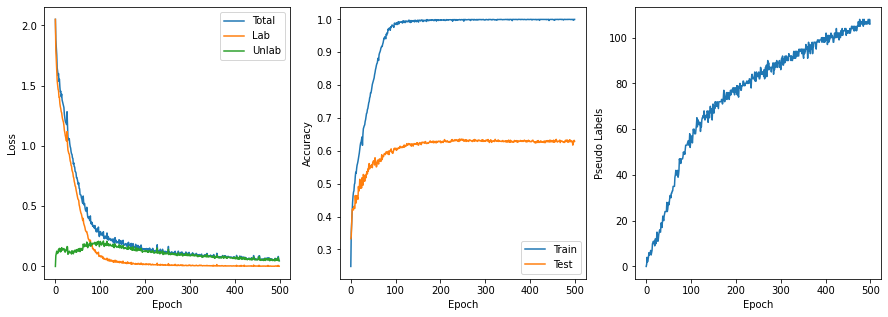

In [ ]:
# Plot the results (losses, accuracies, pseudo labels)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(losses, label='Total')
plt.plot(losses_lab, label='Lab')
plt.plot(losses_unlab, label='Unlab')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(pseudo_lab)
plt.xlabel('Epoch')
plt.ylabel('Pseudo Labels')
plt.show()